<a href="https://colab.research.google.com/github/faranak5171/Stable-Diffusion/blob/main/Latent_DiffusionModels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

adapted from : https://github.com/huggingface/notebooks/blob/main/diffusers/stable_diffusion.ipynb

In [1]:
!pip install -q diffusers==0.8.0
!pip install -q transformers scipy ftfy
!pip install -q "ipywidgets>=7,<8"

     |████████████████████████████████| 433 kB 5.9 MB/s 
     |████████████████████████████████| 182 kB 56.8 MB/s 
     |████████████████████████████████| 5.8 MB 21.2 MB/s 
     |████████████████████████████████| 53 kB 1.2 MB/s 
     |████████████████████████████████| 7.6 MB 61.3 MB/s 
     |████████████████████████████████| 1.6 MB 28.6 MB/s 


In [17]:
import os
from PIL import Image,ImageDraw
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
from base64 import b64encode

import torch
from torch import autocast
from torch.nn import functional as F
from diffusers import StableDiffusionPipeline, AutoencoderKL
from diffusers import UNet2DConditionModel, PNDMScheduler, LMSDiscreteScheduler
from diffusers.schedulers.scheduling_ddim import DDIMScheduler
from transformers import CLIPTextModel, CLIPTokenizer
from tqdm.auto import tqdm
from huggingface_hub import notebook_login
from google.colab import output


In [3]:
device = 'cuda'

# Enable a Jupyter widget manager
output.enable_custom_widget_manager()
notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.huggingface/token
Login successful


In [4]:
# Load stable diffusion model to GPU
model_id = "CompVis/stable-diffusion-v1-4"
pipe = StableDiffusionPipeline.from_pretrained(model_id, revision='fp16', torch_dtype=torch.float16, use_auth_token=True)
pipe = pipe.to(device)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Downloading:   0%|          | 0.00/543 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/342 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.63k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/608M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/209 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/307 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/572 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/246M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/472 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/788 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/550 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/167M [00:00<?, ?B/s]

In [14]:
prompt = 'cute shiba inu dog'

# autocast makes the running model a little faster
with autocast(device):
  image = pipe(prompt).images[0]
image.save("generated-image.png")

  0%|          | 0/51 [00:00<?, ?it/s]

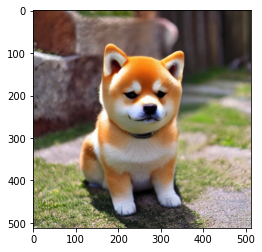

In [18]:
img = cv2.imread('generated-image.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [19]:
# 1. Load the autoencoder model which will be used to decode the latents into image space.
vae = AutoencoderKL.from_pretrained(
    'CompVis/stable-diffusion-v1-4', subfolder='vae', use_auth_token=True
)
vae = vae.to(device)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Downloading:   0%|          | 0.00/335M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/522 [00:00<?, ?B/s]

In [21]:
# 2. Load the tokenizer and text encoder to tokenize and encode the text
tokenizer = CLIPTokenizer.from_pretrained('openai/clip-vit-large-patch14')
text_encoder = CLIPTextModel.from_pretrained('openai/clip-vit-large-patch14')
text_encoder = text_encoder.to(device)

Downloading:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.8.self_attn.k_proj.bias', 'vision_model.encoder.layers.20.mlp.fc2.bias', 'vision_model.encoder.layers.0.self_attn.v_proj.bias', 'vision_model.encoder.layers.19.layer_norm2.weight', 'vision_model.encoder.layers.12.self_attn.k_proj.bias', 'vision_model.encoder.layers.8.layer_norm2.weight', 'vision_model.encoder.layers.20.self_attn.v_proj.weight', 'vision_model.encoder.layers.5.self_attn.v_proj.weight', 'vision_model.encoder.layers.10.layer_norm2.weight', 'vision_model.encoder.layers.14.mlp.fc1.weight', 'vision_model.encoder.layers.23.self_attn.q_proj.weight', 'vision_model.encoder.layers.10.self_attn.q_proj.bias', 'vision_model.encoder.layers.14.self_attn.k_proj.weight', 'vision_model.encoder.layers.7.layer_norm1.bias', 'vision_model.encoder.layers.3.self_attn.v_proj.bias', 'vision_model.encoder.layers.10.mlp.fc1.weight', 'vision_model.encoder

In [22]:
# The Unet model for generating the latents
unet = UNet2DConditionModel.from_pretrained(model_id, subfolder='unet', use_auth_token=True)
unet = unet.to(device)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Downloading:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/743 [00:00<?, ?B/s]